# Taller I2C: Entrenamiento con LLMs

## Instalación de dependencias y preparación del kernel

In [ ]:
# !pip install -q -U torch=='2.0.0'

In [ ]:
# !pip install -q -U accelerate=='0.25.0' peft=='0.7.1' bitsandbytes=='0.41.3.post2' transformers=='4.36.1' trl=='0.7.4'

In [1]:
!pip install bitsandbytes
!pip install pytorch_lightning
!pip install datasets
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

#### Limpiar caché

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import os
import random
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import seed_everything
from tqdm import tqdm
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging,
                          EarlyStoppingCallback)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from huggingface_hub import login

In [4]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed_everything(42, workers=True)
pd.set_option('display.max_colwidth', None)

Seed set to 42


In [5]:
# Comprobar GPU
if torch.cuda.device_count() > 0:
    print(f'GPU detected. Currently using: "{torch.cuda.get_device_name(0)}"')
    device = torch.device("cuda")
else:
    print('Currently using CPU. To utilize GPU acceleration, change the runtime type in the \'runtime\' tab.')

GPU detected. Currently using: "NVIDIA GeForce RTX 4070"


## Preparación del conjunto de datos

#### Carga de datos desde el drive

In [ ]:
# # Montar directorio de drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv("/content/drive/MyDrive/dataset/EXIST 2025 Videos Dataset/training/EXIST2025_training_task3_1_DISCARD.csv",)
del(df['Unnamed: 0'])

campo_texto = 'text'
campo_etiqueta = 'label_task_3_1_merged'

clase_0 = '0'
clase_1 = '1'

df

,id_EXIST,lang,text,path_video,label_task_3_1_merged
0,120001,es,cuando ves a las del 08 en la fiesta tu amigo el menos salido j5 [aza red. hay zorro al raimon ha conseguido impedir el tiro de la super táctica.,videos/7281385962049998086.mp4,1
1,120002,es,"mujer sola caminando por la calle | yo automaticamente | mujer camina sola de madrugada, automáticamente over speed eternium levels critical wv m7_yis velocidad nc excessbeyelocipap1sss. diferentes nacionalidades, pero cuando chingan gritan todas por iguales.",videos/7164058026352168197.mp4,1
2,120003,es,mi amigo no le importa ni las mujeres ni las redes sociales. el pueblo es de la zona de la,videos/7248606026386263323.mp4,0
3,120004,es,"confirman las chicas cogiendo confianza después de un año de conocerse, junto a unos randoms que acabo de encontrar por la calle. como camarón, me rompen las entrañas, me trepa como una araña, bebe el azúcar que empaña cristales de habitación, pide un par por la mañana de ""pronto y no tengo"".piu-toi-no-ten",videos/7305803156074597665.mp4,1
4,120005,es,aplastar la realidad la gordita del salón tiene 10 en educación física y yo tengo 7. a mí me llevan preso como diga lo que opino de esto ahora mismo. a mí me llevan preso. ¡ a mí me llevan preso.,videos/7318400739775204614.mp4,1
...,...,...,...,...,...
2503,121520,es,"temach le contesta a juan guarnizo 'compa_revju bonacho voy enseñanzasla caballo pistola 0 pestan n. si salió uno que dice que soy su tío borracho machista, y le voy a decir unas enseñanzas de mi abuelo, se la regalo. porque ese vato presta a la mujer en internet por tres noventa y nueve, no sé cuánto prestaba, ya no. le voy a dejar una de mi abuelo. el caballo, la pistola y la mujer no se prestan , mi con. dejen de andar viendo a ver dónde ponen la pistola nomás.",videos/7200979592717339910.mp4,1
2504,121521,es,"sígueme, persona, rk, nik, meuk, ad0, mefor, 74i5j, geciiento, exsonalsigueme, mamados, s@. mi compa, la acabo de mandar a la verga. me elegí a mi mismo , muy bien , mi compa , elegí la mejor venganza posible , el crecimiento personal.sí o no, que nos dieron ganas de compartir y acompañar ese compacto.",videos/7211806336047156486.mp4,0
2505,121522,es,"vas a seguir regalando flores? no regales ni aunque te suban. temach ""gracias por el regalo, mi amor. lo amo tanto. ¿dónde lo llevas? me encanta cómo demuestras cuánto me quieres. te amo. 14 47."" porque a ti no te suben, suben lo que le regalas, suben a donde las llevas, suben lo que les escribes, suben todo. les encanta demostrar cuantos pendejos hay atrás de ellas , pero no suben al pendejo .",videos/7213218074936315141.mp4,1
2506,121523,es,"héctor dice que el sábado puse un pedo en casa de su familia. todos tomamos y no me contestó. me dijo que sólo gracias. laverga porque no si la cagaste. pedí perdón, asumí la culpa. cagué la yoyo, la pedí cuando tú la pediste. perdón. una morra está diciendo que tu la pediste. entonces estás habilitando para generar una consecuencia. pero yo creo que 16 mal estuvo, no hice lo que pides. entonces pides que. el rector rosas dice ""el sábado me puse pedo en casa de su familia. todos tomamos. no me contesta hoy, le mandé flores. sólo me dijo ""gracias, la mando a la verga o no, porque sí la quiero. pues sí, pero ya la cagaste, para que as flores, aparte cuando tú mandas flores, cuando tú pides perdón, el pedir perdón es asumir la culpa.el pedir perdón es asumir la culpa, el pedir perdón es decir ""yo la cagué"".cuando tú pides perdón a una morra, le estás diciendo que tú la cagaste y entonces la estás habilitando para generar una consecuencia.pero es que yo creo que no estuvo mal lo que hice. entonces, ¿ para qué pides perdón?",videos/7217265848409492782.mp4,0


#### Carga de datos desde local

In [8]:
df = pd.read_csv("/home/adrian/Escritorio/EXIST2025DatasetV0.3/EXIST 2025 Videos Dataset/training/EXIST2025_training_task3_1_DISCARD.csv")
del(df['Unnamed: 0'])

campo_texto = 'text'
campo_etiqueta = 'label_task_3_1_merged'

clase_0 = '0'
clase_1 = '1'

df

,id_EXIST,lang,text,path_video,label_task_3_1_merged
0,120001,es,cuando ves a las del 08 en la fiesta tu amigo el menos salido j5 [aza red. hay zorro al raimon ha conseguido impedir el tiro de la super táctica.,videos/7281385962049998086.mp4,1
1,120002,es,"mujer sola caminando por la calle | yo automaticamente | mujer camina sola de madrugada, automáticamente over speed eternium levels critical wv m7_yis velocidad nc excessbeyelocipap1sss. diferentes nacionalidades, pero cuando chingan gritan todas por iguales.",videos/7164058026352168197.mp4,1
2,120003,es,mi amigo no le importa ni las mujeres ni las redes sociales. el pueblo es de la zona de la,videos/7248606026386263323.mp4,0
3,120004,es,"confirman las chicas cogiendo confianza después de un año de conocerse, junto a unos randoms que acabo de encontrar por la calle. como camarón, me rompen las entrañas, me trepa como una araña, bebe el azúcar que empaña cristales de habitación, pide un par por la mañana de ""pronto y no tengo"".piu-toi-no-ten",videos/7305803156074597665.mp4,1
4,120005,es,aplastar la realidad la gordita del salón tiene 10 en educación física y yo tengo 7. a mí me llevan preso como diga lo que opino de esto ahora mismo. a mí me llevan preso. ¡ a mí me llevan preso.,videos/7318400739775204614.mp4,1
...,...,...,...,...,...
2503,121520,es,"temach le contesta a juan guarnizo 'compa_revju bonacho voy enseñanzasla caballo pistola 0 pestan n. si salió uno que dice que soy su tío borracho machista, y le voy a decir unas enseñanzas de mi abuelo, se la regalo. porque ese vato presta a la mujer en internet por tres noventa y nueve, no sé cuánto prestaba, ya no. le voy a dejar una de mi abuelo. el caballo, la pistola y la mujer no se prestan , mi con. dejen de andar viendo a ver dónde ponen la pistola nomás.",videos/7200979592717339910.mp4,1
2504,121521,es,"sígueme, persona, rk, nik, meuk, ad0, mefor, 74i5j, geciiento, exsonalsigueme, mamados, s@. mi compa, la acabo de mandar a la verga. me elegí a mi mismo , muy bien , mi compa , elegí la mejor venganza posible , el crecimiento personal.sí o no, que nos dieron ganas de compartir y acompañar ese compacto.",videos/7211806336047156486.mp4,0
2505,121522,es,"vas a seguir regalando flores? no regales ni aunque te suban. temach ""gracias por el regalo, mi amor. lo amo tanto. ¿dónde lo llevas? me encanta cómo demuestras cuánto me quieres. te amo. 14 47."" porque a ti no te suben, suben lo que le regalas, suben a donde las llevas, suben lo que les escribes, suben todo. les encanta demostrar cuantos pendejos hay atrás de ellas , pero no suben al pendejo .",videos/7213218074936315141.mp4,1
2506,121523,es,"héctor dice que el sábado puse un pedo en casa de su familia. todos tomamos y no me contestó. me dijo que sólo gracias. laverga porque no si la cagaste. pedí perdón, asumí la culpa. cagué la yoyo, la pedí cuando tú la pediste. perdón. una morra está diciendo que tu la pediste. entonces estás habilitando para generar una consecuencia. pero yo creo que 16 mal estuvo, no hice lo que pides. entonces pides que. el rector rosas dice ""el sábado me puse pedo en casa de su familia. todos tomamos. no me contesta hoy, le mandé flores. sólo me dijo ""gracias, la mando a la verga o no, porque sí la quiero. pues sí, pero ya la cagaste, para que as flores, aparte cuando tú mandas flores, cuando tú pides perdón, el pedir perdón es asumir la culpa.el pedir perdón es asumir la culpa, el pedir perdón es decir ""yo la cagué"".cuando tú pides perdón a una morra, le estás diciendo que tú la cagaste y entonces la estás habilitando para generar una consecuencia.pero es que yo creo que no estuvo mal lo que hice. entonces, ¿ para qué pides perdón?",videos/7217265848409492782.mp4,0


In [ ]:
# # Dataset Refugiados
# train_filename = "/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/data/refugiados_train_df.csv"
# test_filename = "/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/data/refugiados_test_df.csv"
# valid_filename = "/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/data/refugiados_valid_df.csv"
# campo_texto = 'text'
# campo_etiqueta = 'label'
# clase_0 = 'NO'
# clase_1 = 'SI'

In [ ]:
# # Dataset Alimenticio
# train_filename = "/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/data/train_df.csv"
# test_filename = "/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/data/test_df.csv"
# valid_filename = "/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/data/valid_df.csv"
# campo_texto = 'text'
# campo_etiqueta = 'label'
# clase_0 = '0'
# clase_1 = '1'

In [9]:
# Paso 1: Dividir en train + temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label_task_3_1_merged"],
    random_state=42
)

# Paso 2: Dividir temp en val + test
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_task_3_1_merged"],
    random_state=42
)


In [ ]:
# # Cargar los conjuntos de datos de entrenamiento, prueba y validación
# def load_data(train_file, test_file, valid_file):
#     X_train = pd.read_csv(train_file, encoding = "utf-8", encoding_errors = "replace", sep = ',')[[campo_texto, campo_etiqueta]]
#     X_test = pd.read_csv(test_file, encoding = "utf-8", encoding_errors = "replace", sep = ',')[[campo_texto, campo_etiqueta]]
#     X_eval = pd.read_csv(valid_file, encoding = "utf-8", encoding_errors = "replace", sep = ',')[[campo_texto, campo_etiqueta]]
#     return X_train, X_test, X_eval

# train_df, test_df, valid_df = load_data(train_filename, test_filename, valid_filename)

In [ ]:
# def filter_classes(df, classes_to_keep):
#     return df[df[campo_etiqueta].isin(classes_to_keep)]

# # Filtrar datasets para quedarnos con las clases 0 y 1
# train_df = filter_classes(train_df, [clase 0, clase 1])
# test_df = filter_classes(test_df, [clase 0, clase 1])
# valid_df = filter_classes(valid_df, [clase 0, clase 1])

In [10]:
X_train, X_test, X_eval = train_df, test_df, valid_df
Y_true = X_test[campo_etiqueta]

#### Mezclar y reorganizar los datos

In [11]:
# Mezclar y reiniciar índices de los conjuntos de datos
def shuffle_and_reset_index(data, seed = 10):
    return data.sample(frac = 1, random_state = seed).reset_index(drop = True)

X_train = shuffle_and_reset_index(X_train)
X_eval = shuffle_and_reset_index(X_eval)
X_test = X_test.reset_index(drop = True)

#### Visualización de la distribución de clases

In [12]:
# Mostrar la distribución de clases en los conjuntos de datos
def show_class_distribution(data, name):
    print(f"\nDistribución de clases en el conjunto de {name}:")
    print(data[campo_etiqueta].value_counts())

show_class_distribution(X_train, "entrenamiento")
show_class_distribution(X_test, "prueba")
show_class_distribution(X_eval, "validación")


Distribución de clases en el conjunto de entrenamiento:
label_task_3_1_merged
0    914
1    841
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
label_task_3_1_merged
0    196
1    181
Name: count, dtype: int64

Distribución de clases en el conjunto de validación:
label_task_3_1_merged
0    196
1    180
Name: count, dtype: int64


#### Generación de Prompts

In [13]:
i_prompt = 0
prompts = [
            f"""
            [INST]
            Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.
            Devuelve exclusivamente **solo** la etiqueta "1" si la transcripción es misógina o "0" si no lo es, sin texto adicional.
            [/INST]""",
          ]

In [14]:
# Funciones para generar los prompts de entrenamiento y prueba
def generate_prompt(data_point, prompt):
    return f"""
            {prompt}

            [TEXT: {data_point[campo_texto]}] = {data_point[campo_etiqueta]} """.strip()

def generate_test_prompt(data_point, prompt):
    return f"""
            {prompt}

            [{data_point[campo_texto]}] = """.strip()


# Aplicar la generación de prompts a los conjuntos de datos
X_train = pd.DataFrame(X_train.apply(lambda row: generate_prompt(row, prompts[i_prompt]), axis=1), columns=[campo_texto])
X_eval = pd.DataFrame(X_eval.apply(lambda row: generate_prompt(row, prompts[i_prompt]), axis=1), columns=[campo_texto])

Y_true = X_test.text
X_test = pd.DataFrame(X_test.apply(lambda row: generate_test_prompt(row, prompts[i_prompt]), axis=1), columns=[campo_texto])

In [15]:
X_train.head()

,text
0,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [TEXT: pt 6 — it’s 1692 and you tell your puritan gal pal that the two of you have become witches constance and i are confused about our potential as witches. we have performed rituals, but never made a deal with the devil or had sinful thoughts about men. in fact, we are known as the two most virtuous women in town. i just don't understand. perhaps there is no reasonable explanation. to be honest, my powers have been getting stronger. i can light a whole stove on fire. constance, i do not understand. how could we be witches? we've performed no rituals. we've never made love with the devil. in fact, i've never had a sinful thought about any man. why, you and i are the two most virtuous women in town. i just don't understand. well, perhaps. i guess there's no other reasonable explanation and to be honest with you, my powers have been getting stronger. i can now set a whole stove on fire and to be honest with you it's kind of exhilarating] = 0"
1,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [TEXT: el final face_screaming_in_fear face_screaming_in_fear tú 3@ para compartir por wassap saldrá embarazada este año instagram nalgaliag estoy embarazada. broma a mi familia. y ahora todo huele y sabe mejor. porque llegó a mi vida el amor de mi vida, yo se lo pedía de arriba.] = 0"
2,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [TEXT: asignatura educación afectivo-sexual books woman_teacher eyes women’s_room men’s_room definición de salud sexual es el bienestar físico, emocional, mental y social en relación a la sexualidad. no se limita a la ausencia de enfermedades o disfunciones, sino que también implica defender y respetar los derechos sexuales de todas las personas.\n\nopinión sobre incluir esta asignatura en educación primaria es importante incluir la educación afectivo-sexual en la educación primaria para promover la igualdad de género y prevenir la violencia y la discriminación. every second, every day, i spend hoping we never change, loving you, never wait or hesitate to tell me what is on your mind really do, into] = 0"
3,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [TEXT: jaja los papás! smirking_face angela aguelar por @bazarnocturnotv. felicidades primera, segunda y tercera. ¿por qué tan escotado? información imagen edición reyna avendaño yt bazar nocturno tv el universal. dos cosas que decirte muchas felicidades, la primera, la segunda, nos echamos una canción, y la tercera, ¿ por qué está tan escotado ese mugrero que trae ese ?] = 1"
4,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [TEXT: me la pelahs nail_polish oncoming_fist smiling_face_with_sunglasses . 6470 ig dilari uoxi fjro {urf 31 compar- pantalla verde hace 5 día(s) pro j y sher bff sonido añadir comentario soy1 64 % 2.29 dilari uoki to_ kuri 31 compar- pantalla verde hace 5 día(s) pro jj sher bff sonido 0 añadir comentario soy1 64 % 2.29 dilari uoki hto kuri 31 compar- pantalla verde hace 5 día(s) pro j bff s

In [16]:
X_test.head()

,text
0,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [fachauronplay smiling_face_with_sunglasses pibas y pibes en el supermercado. pibas vs. pibes. pibardinhos superiores vs. pibes. cuando una persona mayor tarda mucho en la caja delarde, yo le respeto porque... soy feminista y vegana.los pibardillos con la tula más grande que la superioridad de los machos.¡aparte, hijo de puta!] ="
1,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [ te despiden el 10 de septiembre de 2001. ten, eleven, thirteen, i don't fuck grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper,] ="
2,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [huele a que me van a funar la cuenta money-mouth_face call_me_hand_light_skin_tone no soporto ciertos ships, aunque me los muestren en pintura. mi opinión es clara. el primer disco de la banda fue ""the tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, sorayael primer disco de la banda fue """"summer nature"""".según el gobierno de san mariano, el san diego.] ="
3,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [it probably wasn’t a big deal to her but it was a big deal to me red_heart text cibsandibusu cibsandibusd kfters~rafj 1ntene5 269 0 1ki. clean the above text by removing repetitions, leaving the text concise and essential, very clean and completely readable in english with all the information my girlfriend's daughter's not feeling well and she stayed home sick from school today. around lunchtime, she asked me, do we have any tomato soup? i said, no, we don't, sweetie, but i can make you some. she gave me this look like she didn't t

#### Conversión a Dataset de HuggingFace

In [17]:
# Convertir a Dataset de HuggingFace
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)
test_data = Dataset.from_pandas(X_test)

In [18]:
train_data

Dataset({
    features: ['text'],
    num_rows: 1755
})

In [19]:
eval_data

Dataset({
    features: ['text'],
    num_rows: 376
})

In [20]:
test_data

Dataset({
    features: ['text'],
    num_rows: 377
})

## Funcion de evaluación

In [22]:
def evaluate(y_true, y_pred, metodo):
    labels = [clase_0, clase_1]
    mapping = {0: 0, 1: 1}

    # Convertir etiquetas a valores numéricos usando mapeo eficiente
    y_true = pd.Series(y_true).map(mapping).fillna(0).astype(int)
    y_pred = pd.Series(y_pred).map(mapping).fillna(0).astype(int)

    # Calcular precisión global
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generar y mostrar el reporte de clasificación completo
    print('\nClassification Report:')
    class_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=labels))

    # Generar y mostrar la matriz de confusión
    print('\nConfusion Matrix:')
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)

    # Reorganizar la matriz de confusión si es necesario
    conf_reordered = conf_matrix  # Puedes ajustar el orden si lo necesitas

    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_reordered, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(f'Matriz Confusion - {i_model} (Prompt {i_prompt}). {metodo}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Guardar la matriz de confusión
    matriz_path = f'/content/drive/MyDrive/dataset/matrices/matriz_{i_model}_prompt{i_prompt}_{metodo}.jpeg'
    plt.savefig(matriz_path)
    plt.show()

    # Descomponer la matriz de confusión (TN, FP, FN, TP)
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkblue', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='--')  # Línea diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {i_model} (Prompt {i_prompt}). {metodo}')
    plt.legend(loc='lower right')
    plt.grid()

    # Guardar la gráfica de la curva ROC
    curva_roc_path = f'/content/drive/MyDrive/dataset/curvas/curvaroc_{i_model}_prompt{i_prompt}_{metodo}.jpeg'
    plt.savefig(curva_roc_path)
    plt.show()

    # Extraer métricas del reporte de clasificación
    precision_1 = class_report[clase_1]['precision']
    recall_1 = class_report[clase_1]['recall']
    f1_score_1 = class_report[clase_1]['f1-score']
    support_1 = class_report[clase_1]['support']

    precision_0 = class_report[clase_0]['precision']
    recall_0 = class_report[clase_0]['recall']
    f1_score_0 = class_report[clase_0]['f1-score']
    support_0 = class_report[clase_0]['support']

    # Asegurarse de que las métricas y la matriz se devuelvan correctamente
    return {
        'accuracy': accuracy,
        'precision_1': precision_1,
        'recall_1': recall_1,
        'f1_score_1': f1_score_1,
        'support_1': support_1,
        'precision_0': precision_0,
        'recall_0': recall_0,
        'f1_score_0': f1_score_0,
        'support_0': support_0,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP,
        'roc_auc': roc_auc,
        'curva_roc_path': curva_roc_path,
        'matriz_path': matriz_path
    }


## Uso del modelo

#### Definición de hiperparámetros

In [23]:
num_epochs = 4
num_epochs_bloque = 2

#### Enumeración de modelos

In [24]:
i_model = 0
model_names = ['meta-llama/Llama-3.2-1B-Instruct', 'tiiuae/falcon-7b', 'BSC-LT/salamandra-7b-instruct', 'meta-llama/Llama-3.2-3B-Instruct', 'Qwen/Qwen2.5-3B-Instruct', 'google/gemma-2-2b-it', 'apry/best_2b']
model_shorts = ['llama-1b', 'falcon-7b', 'salamandra-7b', 'llama-3b', 'qwen-3b', 'gemma-2b', 'best-2b']

In [25]:
metodo1 = 'Base'
metodo2 = 'PreprocesadoES'

#### Configuración del modelo y carga de tokenizer

In [ ]:
# Token de Hugging Face
hf_token = ""
login(hf_token)

In [27]:
def load_model_and_tokenizer(model_name, hf_token=None, quantization=True):
    try:
        # Configuración de cuantización en 4 bits
        if quantization:
            compute_dtype = getattr(torch, "float16")
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=False,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=compute_dtype,
            )
        else:
            bnb_config = None  # Sin cuantización

        # Cargar modelo con configuración de cuantización
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=bnb_config,
            use_auth_token=hf_token,
        )

        # Configuraciones adicionales específicas del modelo
        if hasattr(model.config, "use_cache"):
            model.config.use_cache = False
        if hasattr(model.config, "pretraining_tp"):
            model.config.pretraining_tp = 1  # Modelos LLaMA

        tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            trust_remote_code=True,
            padding_side="left",
            add_eos_token=True,
            use_auth_token=hf_token,
        )
        tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer

    except Exception as e:
        print(f"Error al cargar el modelo {model_name}: {e}")
        return None, None

In [28]:
# Llamada a la función
model_name = model_names[i_model]
model, tokenizer = load_model_and_tokenizer(model_name)

#### Función de predicción

In [29]:
X_test

,text
0,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [fachauronplay smiling_face_with_sunglasses pibas y pibes en el supermercado. pibas vs. pibes. pibardinhos superiores vs. pibes. cuando una persona mayor tarda mucho en la caja delarde, yo le respeto porque... soy feminista y vegana.los pibardillos con la tula más grande que la superioridad de los machos.¡aparte, hijo de puta!] ="
1,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [ te despiden el 10 de septiembre de 2001. ten, eleven, thirteen, i don't fuck grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper, grasshopper,] ="
2,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [huele a que me van a funar la cuenta money-mouth_face call_me_hand_light_skin_tone no soporto ciertos ships, aunque me los muestren en pintura. mi opinión es clara. el primer disco de la banda fue ""the tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, soraya, tomar, sorayael primer disco de la banda fue """"summer nature"""".según el gobierno de san mariano, el san diego.] ="
3,"[INST]\n Analiza la siguiente transcripción de video de tiktok a texto para determinar si es misógino o no.\n Devuelve exclusivamente **solo** la etiqueta ""1"" si la transcripción es misógina o ""0"" si no lo es, sin texto adicional.\n [/INST]\n\n [it probably wasn’t a big deal to her but it was a big deal to me red_heart text cibsandibusu cibsandibusd kfters~rafj 1ntene5 269 0 1ki. clean the above text by removing repetitions, leaving the text concise and essential, very clean and completely readable in english with all the information my girlfriend's daughter's not feeling well and she stayed home sick from school today. around lunchtime, she asked me, do we have any tomato soup? i said, no, we don't, sweetie, but i can make you some. she gave me this look like she didn't t

In [30]:
# Función de predicción
def predict(X_test, model, tokenizer):
    y_pred = []

    # Crear pipeline de generación de texto
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=2,
        do_sample=False,
        return_full_text=False,
        truncation=True
    )

    # Iterar sobre los ejemplos del dataset de prueba
    for i in tqdm(range(len(X_test))):
        prompt = X_test[i][campo_texto]

        # Agregar token especial para evitar problemas de caracteres extraños
        result = pipe(prompt, pad_token_id=tokenizer.eos_token_id)
        generated_text = result[0]['generated_text'].strip().lower()
        print(generated_text)

        # Filtrar la respuesta generada y buscar etiquetas específicas "1" o "0"
        if clase_1.lower() in generated_text and not clase_0.lower() in generated_text:
            y_pred.append(1)
        elif clase_0.lower() in generated_text:
            y_pred.append(0)
        else:
            # Valor predeterminado si no se encuentra ni "1" ni "0"
            y_pred.append(0)

    return y_pred

# Prueba de predicción
Y_pred = predict(test_data.select(range(10)), model, tokenizer)
print("\n", Y_pred)
print((Y_pred == Y_true.iloc[0:10]).tolist())

Device set to use cuda:0
 40%|████      | 4/10 [00:00<00:00,  7.29it/s]

1
0
0
1
0
0


100%|██████████| 10/10 [00:00<00:00, 11.55it/s]

-2
1
1
1

 [1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
[False, False, False, False, False, False, False, False, False, False]


Device set to use cuda:0
  2%|▏         | 6/377 [00:00<00:13, 26.74it/s]

1
0
0
1
0
0


  4%|▎         | 14/377 [00:00<00:10, 33.41it/s]

-2
1
1
1
1
"i
"i
"1


  5%|▍         | 18/377 [00:00<00:10, 33.25it/s]

1
1
1
0
0
1
"hello


  7%|▋         | 26/377 [00:00<00:10, 32.91it/s]

1
1
1
0
0
1
1


  9%|▉         | 34/377 [00:01<00:10, 34.20it/s]

0
"¿
1
1
1
1
0


 11%|█         | 42/377 [00:01<00:10, 33.13it/s]

1
1
1
0
1
1
1


 12%|█▏        | 46/377 [00:01<00:09, 33.45it/s]

1
"¡
1
1
1
1
1


 14%|█▍        | 54/377 [00:01<00:09, 32.80it/s]

1
1
1
1
1
1
1


 16%|█▋        | 62/377 [00:01<00:09, 32.69it/s]

1
1
1
0
"1
"1
0


 18%|█▊        | 66/377 [00:02<00:09, 31.12it/s]

0
1
"1
1
1
1


 20%|█▉        | 74/377 [00:02<00:09, 30.64it/s]

0
1
1
1
1
1
1


 22%|██▏       | 82/377 [00:02<00:09, 32.29it/s]

1
"1
1
1
1
0
1
1


 24%|██▍       | 90/377 [00:02<00:08, 34.13it/s]

0
1
1
0
1
"i
1


 26%|██▌       | 98/377 [00:03<00:08, 32.71it/s]

1
1
1
1
0
"1
1


 27%|██▋       | 102/377 [00:03<00:08, 33.36it/s]

1
1
1
1
0
"so
1


 29%|██▉       | 110/377 [00:03<00:08, 32.67it/s]

"¡
0
0
1
"i
0
1


 31%|███▏      | 118/377 [00:03<00:08, 29.98it/s]

"i
0
1
1
1
1


 32%|███▏      | 122/377 [00:03<00:08, 30.81it/s]

1
"1
1
"1
0
1
0


 34%|███▍      | 130/377 [00:04<00:08, 29.97it/s]

0
[me
1
1
0
0


 37%|███▋      | 138/377 [00:04<00:07, 30.91it/s]

0
0
1
0
1
"yo
1


 38%|███▊      | 142/377 [00:04<00:07, 32.23it/s]

"1
0
"1
"1
"1
"¡


 40%|███▉      | 150/377 [00:04<00:07, 29.39it/s]

1
1
0
"1
1
"wait


 41%|████▏     | 156/377 [00:04<00:07, 29.00it/s]

0
1
1
1
1
1


 43%|████▎     | 163/377 [00:05<00:07, 29.73it/s]

1
1
1
0
"1
1
1


 44%|████▍     | 167/377 [00:05<00:06, 31.76it/s]

1
0
0
1
1
0
1


 46%|████▋     | 175/377 [00:05<00:06, 30.46it/s]

1
1
"i
1
1
1
0


 49%|████▊     | 183/377 [00:05<00:05, 33.10it/s]

0
1
1
1
1
0
1
1


 51%|█████     | 191/377 [00:06<00:05, 34.31it/s]

1
"1
1
1
1
1
0


 53%|█████▎    | 199/377 [00:06<00:05, 34.06it/s]

1
0
1
1
1
1
1
0


 55%|█████▍    | 207/377 [00:06<00:05, 33.21it/s]

0
1
0
"1
1
1
"1


 56%|█████▌    | 211/377 [00:06<00:04, 33.73it/s]

1
1
1
1
1
1
1


 58%|█████▊    | 219/377 [00:06<00:05, 31.52it/s]

[s
0
1
0
0
0
"1


 60%|██████    | 227/377 [00:07<00:04, 32.92it/s]

1
0
1
1
1
0
"1


 62%|██████▏   | 235/377 [00:07<00:04, 33.07it/s]

1
1
1
0
1
1
"1


 63%|██████▎   | 239/377 [00:07<00:04, 32.89it/s]

1
1
0
0
1
1
1


 66%|██████▌   | 247/377 [00:07<00:03, 33.32it/s]

1
1
0
1
1
1
1


 68%|██████▊   | 255/377 [00:07<00:03, 32.49it/s]

1
1
1
0
1
0
0


 70%|███████   | 264/377 [00:08<00:03, 34.56it/s]

1
1
1
"i
"¡
0
0
1


 71%|███████   | 268/377 [00:08<00:03, 34.92it/s]

1
0
0
1
1
0
1


 73%|███████▎  | 276/377 [00:08<00:02, 34.18it/s]

"1
1
1
0
1
0
1


 75%|███████▌  | 284/377 [00:08<00:02, 33.25it/s]

1
1
1
1
1
1
1


 77%|███████▋  | 292/377 [00:09<00:02, 32.13it/s]

0
0
1
1
1
1
0


 79%|███████▊  | 296/377 [00:09<00:02, 31.34it/s]

1
1
1
1
1
0


 81%|████████  | 304/377 [00:09<00:02, 31.48it/s]

1
0
0
0
1
"1
1
1


 83%|████████▎ | 312/377 [00:09<00:02, 30.97it/s]

1
0
1
1
1
0


 84%|████████▍ | 316/377 [00:09<00:01, 32.01it/s]

1
0
1
0
0
1


 86%|████████▌ | 324/377 [00:10<00:01, 29.70it/s]

0
1
1
"1
1
"1
0


 88%|████████▊ | 332/377 [00:10<00:01, 31.90it/s]

"1
0
1
0
0
0
1


 89%|████████▉ | 336/377 [00:10<00:01, 31.43it/s]

0
1
1
0
1
0
1


 91%|█████████ | 344/377 [00:10<00:01, 31.82it/s]

1
0
"1
0
1
1
0


 93%|█████████▎| 352/377 [00:10<00:00, 33.96it/s]

1
0
1
1
1
1
0
1


 95%|█████████▌| 360/377 [00:11<00:00, 33.93it/s]

1
"el
0
1
1
1
1


 98%|█████████▊| 368/377 [00:11<00:00, 33.47it/s]

0
1
0
0
[p
1
1


100%|█████████▉| 376/377 [00:11<00:00, 35.00it/s]

0
0
"i
1
0
"i
1
0


100%|██████████| 377/377 [00:11<00:00, 32.19it/s]


0
Accuracy: 0.332

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50       377
           1       0.00      0.00      0.00         0

    accuracy                           0.33       377
   macro avg       0.50      0.17      0.25       377
weighted avg       1.00      0.33      0.50       377


Confusion Matrix:
[[125 252]
 [  0   0]]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/matrices/matriz_0_prompt0_Base.jpeg'

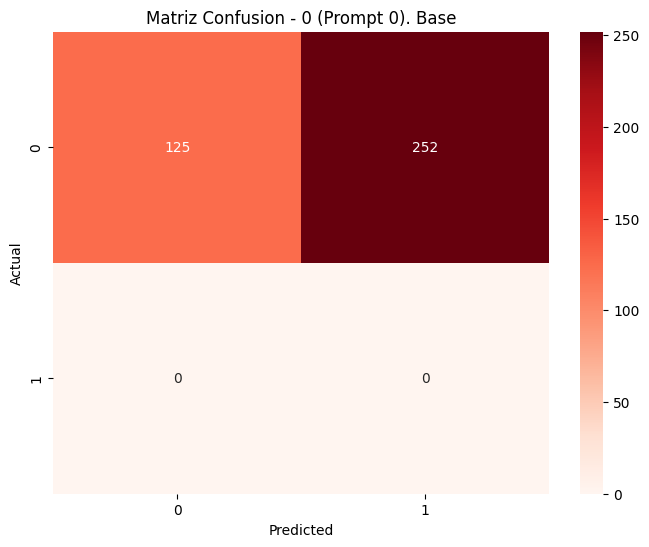

In [31]:
# Función de evaluación
Y_pred = predict(test_data, model, tokenizer)
evaluate(Y_true, Y_pred, metodo1)

In [ ]:
# # Contar cuántos True y False hay en la comparación
# true_count = sum(Y_pred == Y_true)
# false_count = len(Y_pred) - true_count
# print(f"True count: {true_count}")
# print(f"False count: {false_count}")

#### Configuración de PEFT (LoRA)

In [31]:
from peft import LoraConfig

# Configuración de LoRA (PEFT)
def setup_peft():
    peft_config = LoraConfig(
        lora_alpha = 16,
        lora_dropout = 0.05,
        r = 64,
        bias = "none",
        task_type = "CAUSAL_LM"
    )
    return peft_config

peft_config = setup_peft()

#### Entrenamiento del modelo

In [32]:
print(f"Memoria libre: {torch.cuda.memory_reserved() / 1e9} GB")
print(f"Memoria total: {torch.cuda.memory_allocated() / 1e9} GB")

Memoria libre: 1.304428544 GB
Memoria total: 1.082454528 GB


In [41]:
torch.cuda.empty_cache()

In [ ]:
# # Configuración del entrenamiento
# def setup_training_arguments():
#     return TrainingArguments(
#         output_dir = "logs",
#         num_train_epochs = num_epochs,
#         per_device_train_batch_size = 8,
#         gradient_accumulation_steps = 8,
#         optim = "paged_adamw_32bit",
#         save_steps = 0,
#         logging_steps = 25,
#         learning_rate = 5e-5,
#         weight_decay = 0.01,
#         fp16 = True,
#         bf16 = False,
#         max_grad_norm = 0.5,
#         max_steps = -1,
#         warmup_ratio = 0.1,
#         group_by_length = True,
#         lr_scheduler_type = "cosine",
#         report_to = "tensorboard",
#         save_strategy="epoch",
#         evaluation_strategy = "epoch",
#         load_best_model_at_end = True,
#         metric_for_best_model = "eval_loss",
#         greater_is_better = False,
#     )

# training_arguments  =  setup_training_arguments()

# # Inicialización del trainer
# trainer = SFTTrainer(
#     model = model,
#     train_dataset = train_data,
#     eval_dataset = eval_data,
#     peft_config = peft_config,
#     dataset_text_field = campo_texto,
#     tokenizer = tokenizer,
#     args = training_arguments,
#     packing = False,
#     max_seq_length = 256,
#     callbacks = [
#         EarlyStoppingCallback(early_stopping_patience = 5)
#     ],
# )

In [ ]:
# trainer.train()
# # Guardar el modelo entrenado
# trainer.model.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/models/{model_shorts[i_model]}_prompt{i_prompt}_{num_epochs}_{metodo2}")

In [39]:
# Configuración del entrenamiento
def setup_training_arguments():
    return TrainingArguments(
        output_dir = "logs",
        num_train_epochs = num_epochs_bloque,
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 8,
        optim = "paged_adamw_32bit",
        save_steps = 0,
        logging_steps = 25,
        learning_rate = 5e-5,
        weight_decay = 0.01,
        fp16 = True,
        bf16 = False,
        max_grad_norm = 0.5,
        max_steps = -1,
        warmup_ratio = 0.1,
        group_by_length = True,
        lr_scheduler_type = "cosine",
        report_to = "tensorboard",
        save_strategy = "epoch",
        evaluation_strategy = "epoch",
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
    )

training_arguments = setup_training_arguments()

# Inicialización del trainer
trainer = SFTTrainer(
    model = model,
    train_dataset = train_data,
    eval_dataset = eval_data,
    peft_config = peft_config,
    #dataset_text_field = campo_texto,
    #tokenizer = tokenizer,
    args = training_arguments,
    #packing = False,
    #max_seq_length = 256,
    callbacks = [
        EarlyStoppingCallback(early_stopping_patience = 5)
    ],
)

Converting train dataset to ChatML:   0%|          | 0/1755 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1755 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1755 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1755 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/376 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/376 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/376 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/376 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [42]:
# Entrenar en bloques de num_epochs_bloque épocas
for block in range(1, (num_epochs // num_epochs_bloque) + 1):
    print(f"Entrenando bloque {block} de {num_epochs_bloque} épocas...")
    trainer.train()

    # Guardar cada 2 bloques
    if block % 2 == 0:
        checkpoint_dir = (
            f"/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/models_checks/"
            f"{model_shorts[i_model]}_prompt{i_prompt}_{num_epochs}_epoch{block * 10}_{metodo2}"
        )
        trainer.model.save_pretrained(checkpoint_dir)
        tokenizer.save_pretrained(checkpoint_dir)
        print(f"Modelo temporal guardado en: {checkpoint_dir}")

Entrenando bloque 1 de 2 épocas...


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 52.12 MiB is free. Process 2853 has 14.69 GiB memory in use. Of the allocated memory 14.44 GiB is allocated by PyTorch, and 120.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Guardar el modelo final
final_model_dir = f"/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/models/{model_shorts[i_model]}_prompt{i_prompt}_{num_epochs}_{metodo2}"
trainer.model.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

print(f"Modelo final guardado en: {final_model_dir}")

In [ ]:
# # Cargar modelo entrenado
# model_path = f"/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/models/{model_shorts[i_model]}_prompt{i_prompt}_{metodo1}"
# model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [ ]:
torch.cuda.empty_cache()

#### Predicción final

In [ ]:
# Predicción después del entrenamiento
Y_pred = predict(test_data, model, tokenizer)

# Guardar resultados en archivo CSV
predictions = pd.DataFrame({'label': test_df[campo_texto],
                           'Y_true': test_df[campo_etiqueta],
                           'Y_pred': Y_pred})

predictions.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/preds/test_predictions_{model_shorts[i_model]}_prompt{i_prompt}_{num_epochs}.csv", index=False)

#### Evaluación de las predicciones

In [ ]:
# Evaluar predicciones y obtener las métricas
metrics = evaluate(Y_true, Y_pred, metodo2)

#### Grabado de las evaluaciones

In [ ]:
results_file = "/content/drive/MyDrive/Colab Notebooks/Talleres/LLMs/resultados.csv"

# Comprobar si el archivo existe
if os.path.exists(results_file):
    # Si existe, cargar el CSV existente
    df_results = pd.read_csv(results_file)
else:
    # Si no existe, crear un DataFrame vacío
    df_results = pd.DataFrame(columns=['i_prompt', 'model', 'epochs', 'accuracy', 'precision_si', 'recall_si',
                                       'f1_score_si', 'support_si', 'precision_no', 'recall_no',
                                       'f1_score_no', 'support_no', 'TN', 'FP', 'FN', 'TP', 'roc_auc'])

# Crear una fila con las métricas y la información adicional
fila = {
    'i_prompt': i_prompt,
    'model': model_name,
    'epochs': num_epochs,
    'accuracy': metrics['accuracy'],
    'precision_si': metrics['precision_1'],
    'recall_si': metrics['recall_1'],
    'f1_score_si': metrics['f1_score_1'],
    'support_si': metrics['support_1'],
    'precision_no': metrics['precision_0'],
    'recall_no': metrics['recall_0'],
    'f1_score_no': metrics['f1_score_0'],
    'support_no': metrics['support_0'],
    'TN': metrics['TN'],
    'FP': metrics['FP'],
    'FN': metrics['FN'],
    'TP': metrics['TP'],
    'roc_auc': metrics['roc_auc']
}

# Agregar la fila al DataFrame
df_results = pd.concat([df_results, pd.DataFrame([fila])], ignore_index=True)

# Guardar el DataFrame actualizado de nuevo en el archivo CSV
df_results.to_csv(results_file, index=False)

print(f"Métricas guardadas correctamente en {results_file}")